# Neural networks from scratch
  nnfs.io

In [ ]:
# pip install nnfs

In [1]:
import nnfs
import numpy as np
import matplotlib.pyplot as plt
from nnfs.datasets import spiral_data
import matplotlib.patches as mpatches

np.random.seed(0)

# Chapter 9: Backpropogation
  

In [4]:
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.1 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1,n_neurons))
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.biases
    def backward(self, dvalues):
        # Gradients on parameters
        self.dweights = np.dot(self.inputs.T, dvalues)
        self.dbiases = np.sum(dvalues, axis=0, keepdims=True)
        # Gradient on values
        self.dinputs = np.dot(dvalues, self.weights.T)

class Activation_ReLU:
    # Forward pass
    def forward(self, inputs):
        # Remember input values
        self.inputs = inputs
        # Calculate output values from inputs
        self.output = np.maximum(0, inputs)
        # Backward pass
    def backward(self, dvalues):
        # Since we need to modify original variable,
        # let's make a copy of values first
        self.dinputs = dvalues.copy()
        # Zero gradient where input values were negative
        self.dinputs[self.inputs <= 0] = 0

class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)  # que?
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CCE(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clip = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clip[range(samples), y_true]
        elif len(y_true.shape) == 1:
            correct_confidences = np.sum((y_pred_clip * y_true), axis=1)
        loss = -np.log(correct_confidences)
        return loss

    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        labels = len(dvalues[0])
        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]
        self.dinputs = -y_true / dvalues  # Calculate gradient
        self.dinputs = self.dinputs / samples  # Normalize gradient  

class Activation_Softmax():
    def forward(self, inputs):
        exp_vals = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probs = exp_vals / np.sum(exp_vals, axis=1, keepdims=True)
        self.output = probs
        
class Activation_Softmax_Loss_CategoricalCrossentropy():
    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CCE()
        # Forward pass
    def forward(self, inputs, y_true):
    # Output layer's activation function
        self.activation.forward(inputs)
        # Set the output
        self.output = self.activation.output
        # Calculate and return loss value
        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        # Number of samples
        samples = len(dvalues)
        # If labels are one-hot encoded,
        # turn them into discrete values
        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)
        # Copy so we can safely modify
        self.dinputs = dvalues.copy()
        # Calculate gradient
        self.dinputs[range(samples), y_true] -= 1
        # Normalize gradient
        self.dinputs = self.dinputs / samples

In [11]:
# Create dataset
X, y = spiral_data(samples=100, classes=3)
# Create Dense layer with 2 input features and 3 output values
dense1 = Layer_Dense(2, 3)
# Create ReLU activation (to be used with Dense layer):
activation1 = Activation_ReLU()
# Create second Dense layer with 3 input features (as we take output
# of previous layer here) and 3 output values (output values)
dense2 = Layer_Dense(3, 3)
# Create Softmax classifier's combined loss and activation
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
# Perform a forward pass of our training data through this layer
dense1.forward(X)
# Perform a forward pass through activation function
# takes the output of first dense layer here
activation1.forward(dense1.output)
# Perform a forward pass through second Dense layer
# takes outputs of activation function of first layer as inputs
dense2.forward(activation1.output)
# Perform a forward pass through the activation/loss function
# takes the output of second dense layer here and returns loss
loss = loss_activation.forward(dense2.output, y)

# Print loss value
print('loss:', loss)
# Calculate accuracy from output of activation2 and targets
# calculate values along first axis
predictions = np.argmax(loss_activation.output, axis=1)
if len(y.shape) == 2:
    y = np.argmax(y, axis=1)
accuracy = np.mean(predictions==y)
# Print accuracy
print('acc:', accuracy)
# Backward pass
loss_activation.backward(loss_activation.output, y)
dense2.backward(loss_activation.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)

loss: 1.098391666591633
acc: 0.3566666666666667


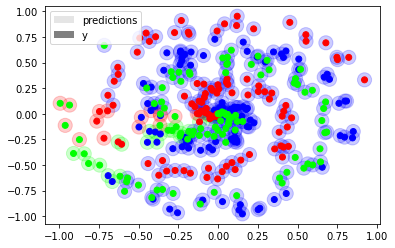

In [31]:
# Plot your predictions
def my_plot(X, y, predictions):

    plt.scatter(X[:,0], X[:,1], c=predictions, s=200, cmap ='brg', alpha = 0.2)
    plt.scatter(X[:,0], X[:,1], c=y, cmap="brg")

    # Create proxy artists for the legend entries
    predictions_patch = mpatches.Circle((0, 0), 1, facecolor='gray', alpha=0.2, edgecolor='none', lw=0, label='predictions')
    y_patch = mpatches.Circle((0, 0), 1, facecolor='gray', edgecolor='none', lw=0, label='y')

    # Add the legend to the plot
    plt.legend(handles=[predictions_patch, y_patch], loc='best')
    plt.show()
    
    return
    
my_plot(X, y, predictions)

So far we have run a backward pass but we havent updated our weights and biases, we can see clearly how bad the predictions are!

# Chapter 10: Optimizers

In [24]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1.0):
        self.learning_rate = learning_rate
    
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.biases += -self.learning_rate * layer.dbiases

## Loop to create epochs

epoch: 0, acc: 0.290, loss: 1.102
epoch: 1000, acc: 0.537, loss: 1.002
epoch: 2000, acc: 0.643, loss: 0.824
epoch: 3000, acc: 0.760, loss: 0.559
epoch: 4000, acc: 0.780, loss: 0.489
epoch: 5000, acc: 0.817, loss: 0.423
epoch: 6000, acc: 0.813, loss: 0.389
epoch: 7000, acc: 0.847, loss: 0.370
epoch: 8000, acc: 0.863, loss: 0.358
epoch: 9000, acc: 0.847, loss: 0.326
epoch: 10000, acc: 0.827, loss: 0.453


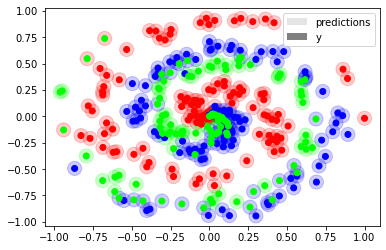

In [32]:
def run_epochs():        
    # Create dataset
    X, y = spiral_data(samples=100, classes=3)
    # Create Dense layer with 2 input features and 64 output values
    dense1 = Layer_Dense(2, 64)
    # Create ReLU activation (to be used with Dense layer):
    activation1 = Activation_ReLU()
    # Create second Dense layer with 64 input features (as we take output
    # of previous layer here) and 3 output values (output values)
    dense2 = Layer_Dense(64, 3)
    # Create Softmax classifier's combined loss and activation
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
    # Create optimizer
    optimizer = Optimizer_SGD()

    for epoch in range(10001):
        dense1.forward(X)
        activation1.forward(dense1.output)
        dense2.forward(activation1.output)
        # Perform a forward pass through the activation/loss function
        # takes the output of second dense layer here and returns loss
        loss = loss_activation.forward(dense2.output, y)

        # Calculate accuracy from output of activation2 and targets
        # calculate values along first axis
        predictions = np.argmax(loss_activation.output, axis=1)
        if len(y.shape) == 2:
            y = np.argmax(y, axis=1)
        accuracy = np.mean(predictions==y)
        if not epoch % 1000:
            print(f'epoch: {epoch}, ' +
            f'acc: {accuracy:.3f}, ' +
            f'loss: {loss:.3f}')

        # Backward pass
        loss_activation.backward(loss_activation.output, y)
        dense2.backward(loss_activation.dinputs)
        activation1.backward(dense2.dinputs)
        dense1.backward(activation1.dinputs)
        # Update weights and biases
        optimizer.update_params(dense1)
        optimizer.update_params(dense2)
    
    my_plot(X, y, predictions)
    return
run_epochs();

# 💥 The machines have learned.
  We can significant improvement after looping through SGD

epoch: 0, acc: 0.340, loss: 1.098
epoch: 1000, acc: 0.830, loss: 0.350
epoch: 2000, acc: 0.740, loss: 0.435
epoch: 3000, acc: 0.743, loss: 0.423
epoch: 4000, acc: 0.753, loss: 0.417
epoch: 5000, acc: 0.753, loss: 0.413
epoch: 6000, acc: 0.747, loss: 0.412
epoch: 7000, acc: 0.753, loss: 0.410
epoch: 8000, acc: 0.747, loss: 0.410
epoch: 9000, acc: 0.743, loss: 0.409
epoch: 10000, acc: 0.750, loss: 0.409


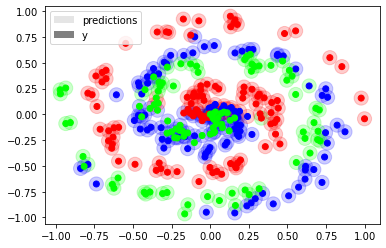

In [33]:
# Updated the Optimizer to include momentum
class Optimizer_SGD:
    def __init__(self, learning_rate=1, decay=1e-3, momentum=0.9):
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.momentum = momentum
    
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate *  (1. / (1. + self.decay * self.iterations))

    def update_params(self, layer):

        if self.momentum:
            #create zeros if non-existant
            if not hasattr(layer, 'weight_momentums'):
                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.biases)
            
            weight_updates = self.momentum*layer.weight_momentums -self.current_learning_rate * layer.dweights
            layer.weight_momentums = weight_updates

            bias_updates =  self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbiases 
            layer.bias_momentums = bias_updates
        
        #vanilla
        else:    
            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbiases

        layer.weights += weight_updates
        layer.biases += bias_updates

    def post_update_params(self):
        self.iterations += 1        

run_epochs();